<a href="https://colab.research.google.com/github/ngoan22mse23088/python4engineers-assignments/blob/master/Assignments_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cài đặt packages version như sau
!pip install opendatasets
!pip install mysql-connector-python
!pip install pandas matplotlib
!apt-get update install mysql-server mysql-client -y
!service mysql start

# cài đặt môi trường mysql trên colab với thông số :
# host : localhost
# user : root
# pass : root
# database : laptop
!mysql -u root -p -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY 'root';"
!mysql -u root -p -e "CREATE DATABASE laptop;"
!mysql -u root -p -e "SHOW DATABASES;"
!mysql -u root -p -e "GRANT ALL PRIVILEGES ON laptop.* TO 'root'@'localhost';"

                             Name     Brand  OldPrice  NewPrice  \
0                 g5 gd 51vn123so  gigabyte     20.49     19.49   
1     nitro 5 eagle an515 57 53f9      acer     25.99     20.99   
2                 g5 ge 51vn263sh  gigabyte     25.59     21.69   
3                 g5 ge 51vn263sh  gigabyte     26.99     21.49   
4                 g5 ge 51vn263sh  gigabyte     20.99     16.99   
5          aspire 7 a715 42g r05g      acer     20.99     16.99   
6          katana gf66 11ue 836vn       msi     32.99     25.99   
7          katana gf66 11ue 836vn       msi     25.99     19.99   
8          aspire 7 a715 43g r8ga      acer     22.99     18.99   
9     nitro 5 eagle an515 57 54mv      acer     25.99     20.79   
10    nitro 5 tiger an515 58 773y      acer     32.99     29.49   
11    rog strix g15 g513ie hn246w      asus     26.99     22.99   
12           gf63 thin 11ud 473vn       msi     22.99     18.99   
13                g5 ge 51vn213sh  gigabyte     26.39     22.9

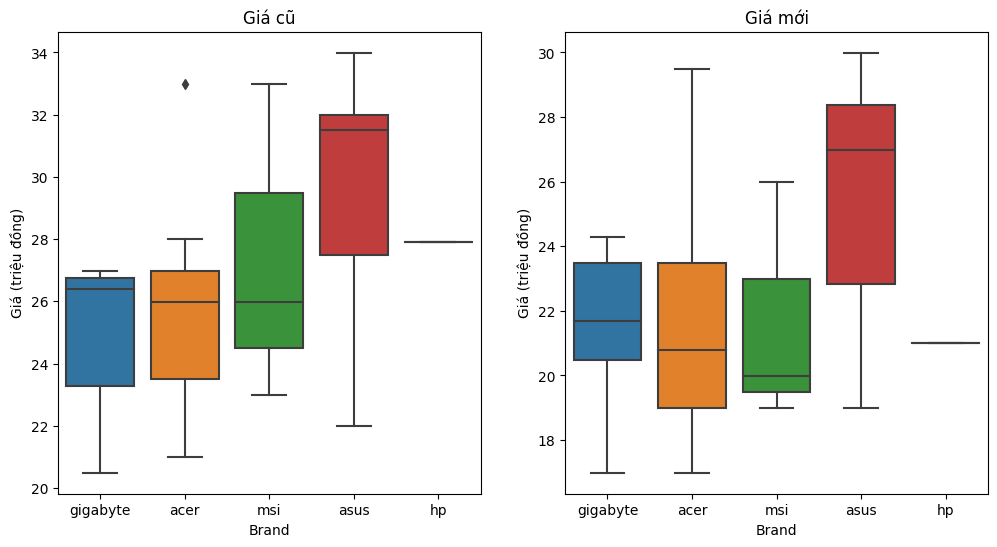

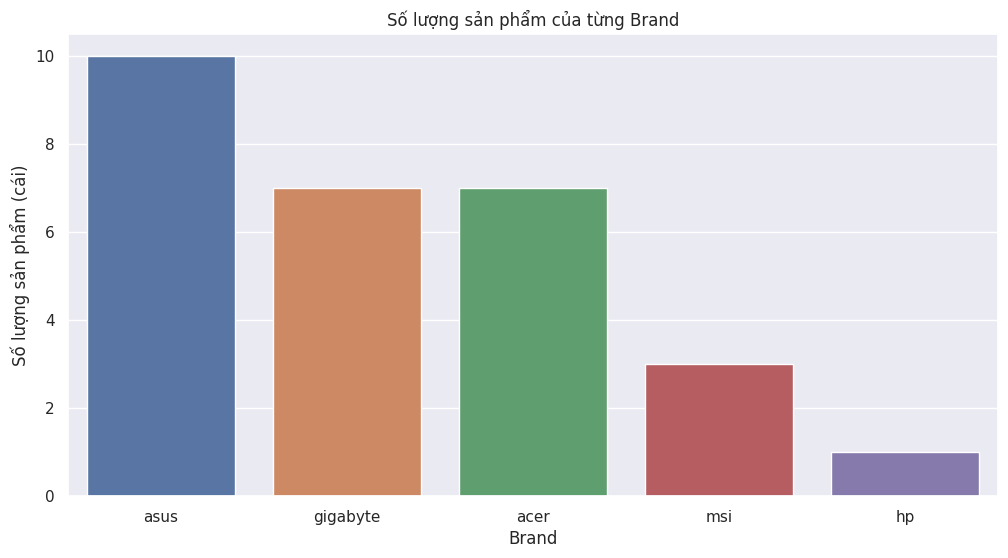

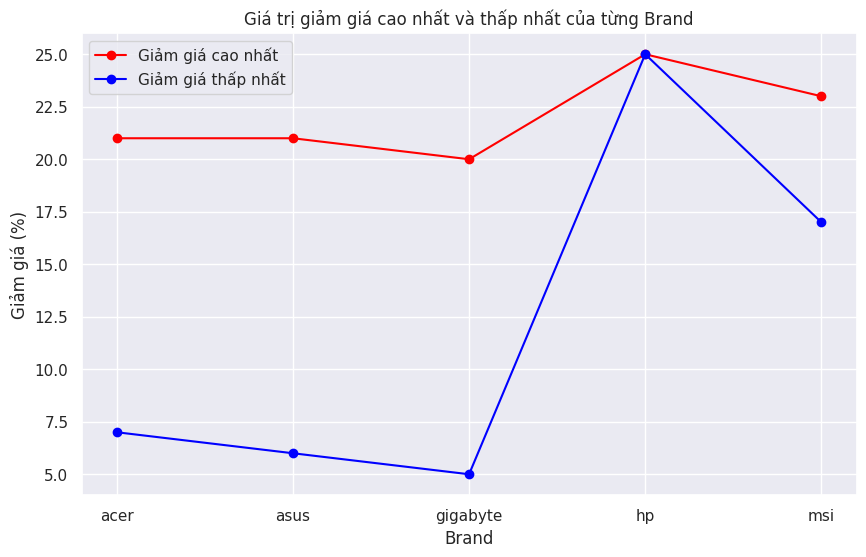

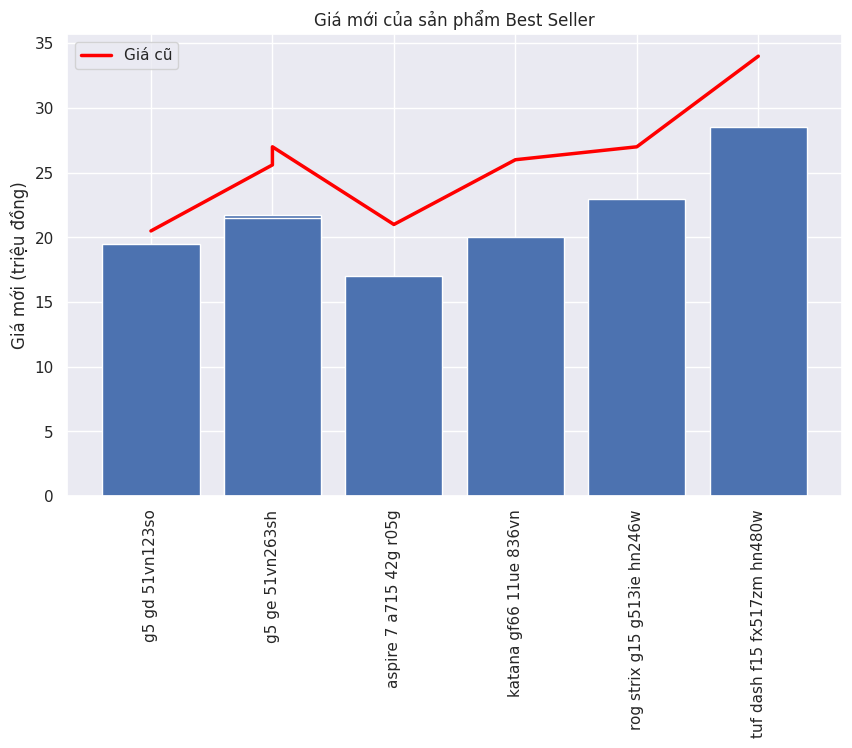

In [ ]:
# Thêm các thư viện cơ bản để xử lý
import re
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Dùng thư viện BeautifulSpup để scraping dữ liệu về
url = 'https://gearvn.com/collections/laptop-gaming-ban-chay'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
products = soup.find_all('div', {'class': 'product-row'})
data = []

# Đọc từng thẻ trong file html để lấy data
for product in products:
    # Đọc giá trị tên
    name = product.find('h2', {'class': 'product-row-name'}).text.strip()
    # Đọc giá trị cũ
    old_price = product.find(
        'div', {'class': 'product-row-price'}).find('del').text.strip()
    # Đọc giá mới
    new_price = product.find('span', {'class': 'product-row-sale'}).text.strip()
    # Đọc giá trị giảm giá
    percent_discount = product.find(
        'div', {'class': 'new-product-percent'}).text.strip()
    # Đọc giá trị best saller (trả về 1 nếu là best seller và ngược lại là 0)
    best_seller = 1 if product.find(
        'span', {'class': 'ico-product ico-km'}) else 0
    # Phân tích chuỗi để lấy tên và brand
    # Case Laptop Gaming và Laptop gaming và Laptop
    match = re.search(r'^laptop gaming (.*)', name.lower())
    if match:
        product_name = match.group(1).strip()
        brand_match = re.search(r'^(.*?)\s+(.*)', product_name)
        if brand_match:
            brand = brand_match.group(1).strip()
            product_name = brand_match.group(2).strip()

    # Lấy giá củ (tính đến đơn vị triệu đồng)
    old_price = int(re.sub(r'[^\d]+', '', old_price))/1000000
    # Lấy giá mới (tính đến đơn vị triệu đồng)
    new_price = int(re.sub(r'[^\d]+', '', new_price))/1000000
    # Lấy phần trăm giảm giá
    percent_discount = int(re.sub(r'[^\d]+', '', percent_discount))

    # Đưa vào mảng để trực quan hóa dữ liệu
    data.append({
        'Name': product_name,
        'Brand': brand,
        'OldPrice': old_price,
        'NewPrice': new_price,
        'PercentDiscount': percent_discount,
        'BestSeller': best_seller
    })

df = pd.DataFrame(data)
# In laptop đã phân tích
print(df)

# Trực quan trung bình và trung vị giá bán cũ và mới với các Brand.
agg_df = df.groupby("Brand").agg({"OldPrice": ["mean", "median"], "NewPrice": ["mean", "median"]})
agg_df.columns = ["Giá cũ (trung bình)", "Giá cũ (trung vị)", "Giá mới (trung bình)", "Giá mới (trung vị)"]
agg_df = agg_df.reset_index()

# Vẽ biểu đồ boxplot
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x="Brand", y="OldPrice", data=df, ax=axs[0])
sns.boxplot(x="Brand", y="NewPrice", data=df, ax=axs[1])

axs[0].set_title("Giá cũ")
axs[1].set_title("Giá mới")

axs[0].set_ylabel("Giá (triệu đồng)")
axs[1].set_ylabel("Giá (triệu đồng)")
plt.show()

# Nhận xét
# Các Brand Laptop Gaming trong dataset có giá bán cũ và mới từ 10 triệu đồng đến 30 triệu đồng, với giá bán mới trung bình và trung vị thấp hơn giá bán cũ.
# Brand MSI có giá bán cũ và mới cao hơn so với các Brand khác, với giá bán mới trung bình và trung vị đều trên 20 triệu đồng.
# Brand Asus có giá bán mới trung bình thấp hơn so với các Brand khác, trong khi Brand Acer có giá bán mới trung vị thấp hơn.

# Trực quan đếm số sản phẩm của các Brand
df = pd.DataFrame(data)
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ
ax = sns.countplot(x="Brand", data=df, order=df['Brand'].value_counts().index)
ax.set_title("Số lượng sản phẩm của từng Brand")
ax.set_xlabel("Brand")
ax.set_ylabel("Số lượng sản phẩm (cái)")
plt.show()

# Nhận xét: Trực quan cho thấy số lượng sản phẩm của từng brand. 
# Các brand như MSI, Asus và Acer có số lượng sản phẩm nhiều hơn so với các brand khác.

# Tính giá trị giảm giá cao nhất và thấp nhất của từng Brand
discount_df = df.groupby("Brand").agg({"PercentDiscount": ["max", "min"]})
discount_df.columns = ["MaxDiscount", "MinDiscount"]
discount_df = discount_df.reset_index()

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))
x = discount_df['Brand']
y1 = discount_df['MaxDiscount']
y2 = discount_df['MinDiscount']

# Vẽ biểu đồ đường thẳng
ax.plot(x, y1, color='red', marker='o', label='Giảm giá cao nhất')
ax.plot(x, y2, color='blue', marker='o', label='Giảm giá thấp nhất')

# Đặt tiêu đề và tên trục
ax.set_title('Giá trị giảm giá cao nhất và thấp nhất của từng Brand')
ax.set_xlabel('Brand')
ax.set_ylabel('Giảm giá (%)')

# Hiển thị chú thích màu
ax.legend(loc='best')
plt.show()

# Nhận xét: Boxplot cho phép chúng ta so sánh mức giảm giá và giá mới của các sản phẩm của các brand khác nhau.
# Chúng ta có thể quan sát được rằng, các sản phẩm của brand Dell, MSI và Lenovo thường có mức giảm giá cao hơn so với các brand khác.
# Tuy nhiên, các sản phẩm của brand Acer và Asus lại có giá trị trung bình và median cao hơn so với các brand khác.
# Boxplot cũng cho thấy rằng, các brand khác nhau có sự phân tán khác nhau về giá và mức giảm giá của sản phẩm của mình.

# Trực quan mức giá mới của các sản phẩm là BestSeller
# create empty lists to store data
best_sellers = []
new_prices = []
old_prices = []

# Lấy sản phẩm là best seller
for item in data:
    if item['BestSeller'] == 1:
        best_sellers.append(item['Name'])
        new_prices.append(item['NewPrice'])
        old_prices.append(item['OldPrice'])

# Tạo bar chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(best_sellers, new_prices)
plt.xticks(rotation=90)
plt.ylabel('Giá mới (triệu đồng)')
plt.title('Giá mới của sản phẩm Best Seller')

# Tạo line chart
plt.plot(best_sellers, old_prices, color='red', linewidth=2.5, label='Giá cũ')
plt.legend()

# Vẽ biểu đồ
plt.show()

# Nhận xét: 
# Dựa trên biểu đồ, ta có thể thấy mức giá mới của các sản phẩm BestSeller khác nhau. 
# Sản phẩm có giá mới cao nhất là tầm 28 đến 30 đơn vị và sản phẩm có giá mới thấp nhất là khoảng 16 đơn vị. 
# Các sản phẩm khác có mức giá mới nằm trong khoảng này. 
# Ta có thể sử dụng thông tin này để so sánh giá của các sản phẩm BestSeller và đưa ra quyết định mua sắm phù hợp.

In [ ]:
# Thêm các thư viện cơ bản để xử lý
from flask import Flask, flash, render_template, request
import mysql.connector
import pymysql

app = Flask(__name__)
app.secret_key = "assignmentFinal"

class Database:
    def connect(self):
        return pymysql.connect(host="localhost", user="root", password="root", database="laptop", charset='utf8mb4')

    def read(self, id):
        con = Database.connect(self)
        cursor = con.cursor()

        try:
            if id == None:
                cursor.execute(
                    "SELECT * FROM laptopbestseller order by Name asc")
            else:
                cursor.execute(
                    "SELECT * FROM laptopbestseller where id = %s order by Name asc", (id))

            return cursor.fetchall()
        except:
            return ()
        finally:
            con.close()

    def get_laptopbestsellers(self):
        con = Database.connect(self)
        cursor = con.cursor()

        try:
            cursor.execute(
                "SELECT Id, Name, Brand, OldPrice, NewPrice, PercentDiscount, BestSeller FROM laptopbestseller")
            data = cursor.fetchall()
            return [LaptopSeller(*laptopSeller) for laptopSeller in data]
        except:
            return ()
        finally:
            con.close()
        pass

    def get_laptopbestseller_by_id(self, id):
        con = Database.connect(self)
        cursor = con.cursor()

        try:
            cursor.execute(
                "SELECT Id, Name, Brand, OldPrice, NewPrice, PercentDiscount, BestSeller FROM laptopbestseller WHERE Id = %s", (id))
            laptop = cursor.fetchone()
            return LaptopSeller(laptop[0], laptop[1], laptop[2], laptop[3], laptop[4], laptop[5], laptop[6])
        except:
            return None
        finally:
            con.close()
        pass

    def insert(self, laptop):
        con = Database.connect(self)
        cursor = con.cursor()

        try:
            cursor.execute("INSERT INTO laptopbestseller (Name, Brand, OldPrice, NewPrice, PercentDiscount, BestSeller) VALUES (%s, %s, %s, %s, %s, %s)",
                           (laptop.name, laptop.brand, laptop.old_price, laptop.new_price, laptop.percent_discount, laptop.best_seller))
            con.commit()

            return True
        except:
            con.rollback()

            return False
        finally:
            con.close()

    def update(self, laptop):
        con = Database.connect(self)
        cursor = con.cursor()

        try:
            cursor.execute("UPDATE laptopbestseller SET Name=%s, Brand=%s, OldPrice=%s, NewPrice=%s, PercentDiscount=%s, BestSeller=%s WHERE Id=%s",
                           (laptop.name, laptop.brand, laptop.old_price, laptop.new_price, laptop.percent_discount, laptop.best_seller, laptop.id))
            con.commit()

            return True
        except:
            con.rollback()

            return False
        finally:
            con.close()

    def delete(self, id):
        con = Database.connect(self)
        cursor = con.cursor()

        try:
            cursor.execute("DELETE FROM laptopbestseller WHERE Id = %s", (id,))
            con.commit()

            return True
        except:
            con.rollback()

            return False
        finally:
            con.close()

class LaptopSeller:
    def __init__(self, id, name, brand, old_price, new_price, percent_discount, best_seller):
        self.id = id
        self.name = name
        self.brand = brand
        self.old_price = old_price
        self.new_price = new_price
        self.percent_discount = percent_discount
        self.best_seller = best_seller

# Kết nối tới MySQL (port mặc định 3306)
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="12345678",
    database="laptop"
)

# Tạo table nếu chưa có
mycursor = mydb.cursor()
mycursor.execute("CREATE TABLE IF NOT EXISTS laptopbestseller (id int NOT NULL AUTO_INCREMENT, Name varchar(255), Brand varchar(255), OldPrice int, NewPrice int, PercentDiscount int, BestSeller int, PRIMARY KEY (id));")

# Trang main
@app.route('/')
def index():
    return render_template('index.html')

# Trang create
@app.route('/create', methods=['GET'])
def create():
    return render_template('create.html')

# Trang get edit với id
@app.route('/edit/<int:id>/', methods=['GET'])
def edit(id):
    laptop = db.get_laptopbestseller_by_id(id)
    return render_template('edit.html', laptop=laptop)

# Trang post edit với id
@app.route('/edit/<int:id>/', methods=['POST'])
def update_edit(id):
    form = request.form
    name = form.get('name')
    brand = form.get('brand')
    old_price = form.get('oldPrice')
    new_price = form.get('newPrice')
    percent_discount = form.get('percentDiscount')
    best_seller = form.get('bestSeller')
    laptop = LaptopSeller(id, name, brand, old_price,
                          new_price, percent_discount, best_seller)
    if db.update(laptop):
        flash("A laptop has been updated")
    else:
        flash("A laptop can not be updated")

    laptop = db.get_laptopbestseller_by_id(id)
    return render_template('edit.html', laptop=laptop)

# Trang danh sách laptop với id
@app.route('/laptop', methods=['GET'])
def laptops():
    laptops = db.get_laptopbestsellers()
    return render_template('laptop.html', laptops=laptops)

# Trang xóa laptop với id
@app.route('/delete/<int:id>', methods=['POST'])
def delete(id):
    if db.delete(id):
        flash("A laptop has been deleted")
    else:
        flash("A laptop can not be deleted")
    return laptops()

# Trang taọ mới laptop với id
@app.route('/create', methods=['POST'])
def addlaptop():
    form = request.form
    name = form.get('name')
    brand = form.get('brand')
    old_price = form.get('oldPrice')
    new_price = form.get('newPrice')
    percent_discount = form.get('percentDiscount')
    best_seller = form.get('bestSeller')
    laptop = LaptopSeller(None, name, brand, old_price,
                          new_price, percent_discount, best_seller)
    if db.insert(laptop):
        flash("A laptop has been added")
    else:
        flash("A laptop can not be added")
    return laptops()

# Trang xử lý lỗi (404 not found)
@app.errorhandler(404)
def page_not_found():
    error_message = "This is an error message."
    return render_template('error.html', error=error_message)

if __name__ == '__main__':
    app.run(port=8181, host="0.0.0.0")
